In [1]:
import os, sys
import torch
import numpy as np
from skimage import io
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
sys.path.append('../')

from src.loss import distance_matrix, get_hardest_points, topk_hardest_mean, batch_hard_loss
from src.dataset import TripletDataset
from src.utils import get_user_dict
from src.models import LinearModel

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

----------------

In [3]:
N = 6
M = 10

In [4]:
to_img = torchvision.transforms.ToPILImage()

In [5]:
def batch_to_img(batch, use_cuda=False):
    if use_cuda:
        batch = batch.cpu()
    
    n_imgs = batch.shape[0]
    batch = batch.reshape(n_imgs, 1, batch.shape[1], batch.shape[2])
    
    return to_img(torchvision.utils.make_grid(batch, nrow = int(np.sqrt(n_imgs))))

In [6]:
def distance_matrix_plot(D, filename = None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(D.detach().numpy())

    for i in range(N):
        plt.axvline(x=M*(i+1)-.5, color='white')
        plt.axhline(y=M*(i+1)-.5, color='white')
    
    if not filename is None:
        fig.savefig(filename)
        plt.close()


--------

### Dataset

In [7]:
user_dict = get_user_dict('../dados/mnist/png/training/')
MNIST = TripletDataset(None, user_dict, M, data_width=28, data_height=28, ignore_color_channel=False, 
                      use_cuda=True)

### Imagens

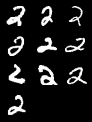

In [8]:
batch_to_img(MNIST[2], True)

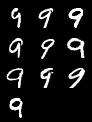

In [9]:
batch_to_img(MNIST[9], True)

### Modelo

In [10]:
class shallowCNN(torch.nn.Module):
    def __init__(self, width = 28, height = 28, h = 300):
        super(shallowCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3)
        self.maxpool2 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=5)
        self.fc1 = torch.nn.Linear(2048, 300)
        self.fc2 = torch.nn.Linear(300, 300)
    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        y = self.conv1(x)
        y = F.relu(self.maxpool2(y))
        y = self.conv2(y)
        y = F.relu(self.maxpool2(y))
        y = y.view(x.shape[0], y.shape[1]*y.shape[2]*y.shape[3])
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        return y

In [11]:
cnn = shallowCNN().cuda()

### Otimizador

In [12]:
optimizer = Adam(cnn.parameters())

### Treinamento

In [13]:
N = 6
M = 10
KP = 1
KN = 10
max_iter = 500

In [14]:
ppath = './Distance_matrix/N=%d, M=%d, KP=%d, KN=%d, %d' % (N, M, KP, KN, max_iter)

if not os.path.exists(ppath):
    os.mkdir(ppath)

In [16]:
n_iter = 0
loss_list = []

while True:
    n_iter += 1
    
    users = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], N, replace=False)
    batch = MNIST[tuple(users)]
    
    batch = batch.view(M*N, 28, 28)
    
    cnn.zero_grad()
    optimizer.zero_grad()
    embeddings = cnn.forward(batch)
    
    D = distance_matrix(embeddings)
    hardest_positives, hardest_negatives = topk_hardest_mean(D, M, N, KP, KN, use_cuda=True)
    loss = batch_hard_loss(hardest_positives, hardest_negatives, 1)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    print('(%d/%d) Loss: %f, H.pos - H.neg: %f' % (n_iter, max_iter, loss.data[0], (max(hardest_positives) - min(hardest_positives))))

    if (n_iter % 10) == 0:
        distance_matrix_plot(D.cpu(), os.path.join(ppath, 'iter_%03d.jpg' % n_iter))
    
    if n_iter == max_iter:
        break

loss_list = np.array(loss_list)
fig = plt.figure(figsize=(8,6))
plt.plot(loss_list)
fig.savefig(os.path.join(ppath, 'loss.png'))
plt.close()

/home/pi/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(1/500) Loss: 1.025717, H.pos - H.neg: 0.048414
(2/500) Loss: 1.020818, H.pos - H.neg: 0.040118
(3/500) Loss: 1.010713, H.pos - H.neg: 0.024783
(4/500) Loss: 1.010243, H.pos - H.neg: 0.017810
(5/500) Loss: 1.004397, H.pos - H.neg: 0.022051
(6/500) Loss: 1.004584, H.pos - H.neg: 0.012784
(7/500) Loss: 1.004427, H.pos - H.neg: 0.015636
(8/500) Loss: 1.007023, H.pos - H.neg: 0.016938
(9/500) Loss: 1.003249, H.pos - H.neg: 0.008410
(10/500) Loss: 1.002855, H.pos - H.neg: 0.009864
(11/500) Loss: 1.002353, H.pos - H.neg: 0.005897
(12/500) Loss: 1.001295, H.pos - H.neg: 0.003658
(13/500) Loss: 1.001670, H.pos - H.neg: 0.003326
(14/500) Loss: 1.000768, H.pos - H.neg: 0.004916
(15/500) Loss: 1.001332, H.pos - H.neg: 0.003588
(16/500) Loss: 1.001254, H.pos - H.neg: 0.003876
(17/500) Loss: 1.000632, H.pos - H.neg: 0.002244
(18/500) Loss: 1.000760, H.pos - H.neg: 0.001767
(19/500) Loss: 1.000425, H.pos - H.neg: 0.002282
(20/500) Loss: 1.000206, H.pos - H.neg: 0.001767
(21/500) Loss: 1.000295, H.po

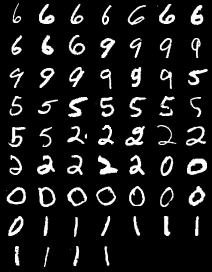

In [17]:
batch_to_img(batch.detach().cpu())

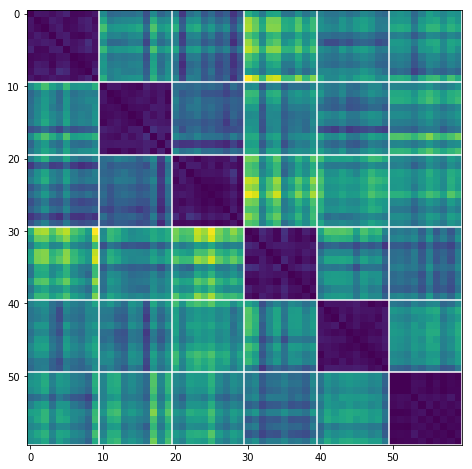

In [18]:
distance_matrix_plot(D.cpu())

## Dataset de Teste

In [19]:
user_dict_teste = get_user_dict('../dados/mnist/png/testing')

In [20]:
L = sum([len(u) for _, u in user_dict_teste.items()])

In [21]:
x_teste = torch.empty((L, 28, 28))
y_teste = torch.empty(L)
i = 0

for label, files in user_dict_teste.items():
    for file in files:
        x_teste[i] = torch.tensor((io.imread(file))/255.0)
        y_teste[i] = int(label)
        i += 1

In [24]:
x_teste.shape

torch.Size([10000, 28, 28])

In [25]:
cnn = cnn.cpu()

In [26]:
first = 5000
sample = np.random.choice(np.arange(L), first, replace=False)

emb_teste = cnn.forward(x_teste[sample].cpu())
y_teste_f = y_teste[sample]

In [84]:
emb_teste = emb_teste.cpu()

### PCA

In [27]:
from sklearn.manifold import TSNE
import pandas as pd
from plotnine import *

In [28]:
emb_teste_tsne = TSNE(n_components=2).fit_transform(emb_teste.detach().numpy())

In [29]:
df = pd.DataFrame({'TSNE-PC1': emb_teste_tsne[:,0], 'TSNE-PC2': emb_teste_tsne[:,1], 'y': y_teste_f})
df['y'] = df['y'].astype('category')

/home/pi/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


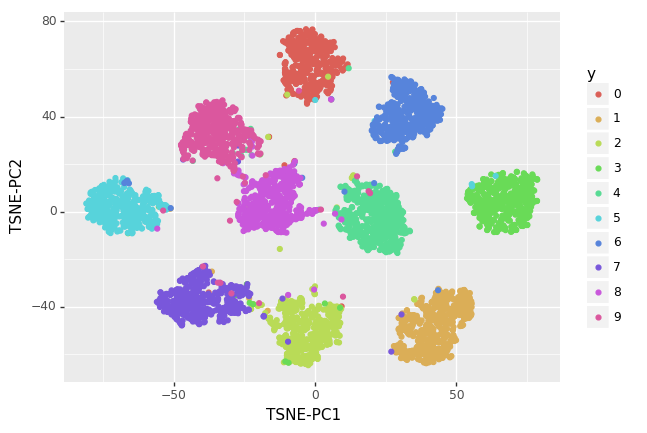

<ggplot: (-9223363274277561277)>

In [30]:
(ggplot(df, aes('TSNE-PC1', 'TSNE-PC2', color = 'y')) +
geom_point())

------------